In [1]:
# 모듈 호출
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
img_size = 224
channel=3

In [5]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        rotation_range=40,      # 40도까지 회전
        width_shift_range=0.2,  # 20%까지 좌우 이동
        height_shift_range=0.2, # 20%까지 상하 이동
        shear_range=0.2,        # 20%까지 기울임
        zoom_range=0.2,         # 20%까지 확대
        horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/train_10',
    batch_size=50,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/valid_10',
    batch_size=20,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/test_10',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 10529 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [6]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
valid_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}
test_generator class :  {'갈아만든배': 0, '레쓰비': 1, '마운틴듀': 2, '밀키스': 3, '스프라이트': 4, '칠성사이다': 5, '코카콜라': 6, '트로피카나망고': 7, '펩시콜라': 8, '환타오렌지': 9}


### 모델 학습하기 - MobileNetV2
- imagenet 전이학습
- 은닉층
    * Flatten(input_shape=(112,112))
    * Dense(224, activation='relu')
    * Dropout(0.2)
- 출력층
    * Dense(10, activation='softmax')
- complie
    * optimizer : adam
    * loss : categorical_crossentropy
    * metrics : accuracy

In [7]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 32

In [8]:
MobileNet = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(img_size, img_size, channel))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten(input_shape=(112,112)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 224)               14049504  
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
Total params: 16,309,738
Trainable params: 14,051,754
Non-trainable params: 2,257,984
____________________________________

In [10]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
model_name = './model/MobileNetV2_04_{epoch:02d}-{val_loss:.4f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_name,
                                                 save_weights_only=True, 
                                                 save_freq="epoch")
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

In [12]:
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=40,
                    callbacks = [[earlystop, cp_callback]]) 

Epoch 1/200
200/200 [==============================] - 5632s 28s/step - loss: 2.0770 - accuracy: 0.6850 - val_loss: 0.2040 - val_accuracy: 0.9388
Epoch 2/200
200/200 [==============================] - 440s 2s/step - loss: 0.3606 - accuracy: 0.8768 - val_loss: 0.1340 - val_accuracy: 0.9613
Epoch 3/200
200/200 [==============================] - 144s 723ms/step - loss: 0.2750 - accuracy: 0.9056 - val_loss: 0.0828 - val_accuracy: 0.9663
Epoch 4/200
200/200 [==============================] - 120s 601ms/step - loss: 0.2386 - accuracy: 0.9179 - val_loss: 0.0634 - val_accuracy: 0.9837
Epoch 5/200
200/200 [==============================] - 118s 588ms/step - loss: 0.2189 - accuracy: 0.9275 - val_loss: 0.0480 - val_accuracy: 0.9900
Epoch 6/200
200/200 [==============================] - 118s 589ms/step - loss: 0.1874 - accuracy: 0.9367 - val_loss: 0.0655 - val_accuracy: 0.9775
Epoch 7/200
200/200 [==============================] - 118s 591ms/step - loss: 0.1733 - accuracy: 0.9399 - val_loss: 0.021

In [13]:
max(history.history['accuracy'])

0.9678324460983276

In [27]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/MobileNetV2_04_model_acc{accuracy}.h5') # 최종 모델 저장

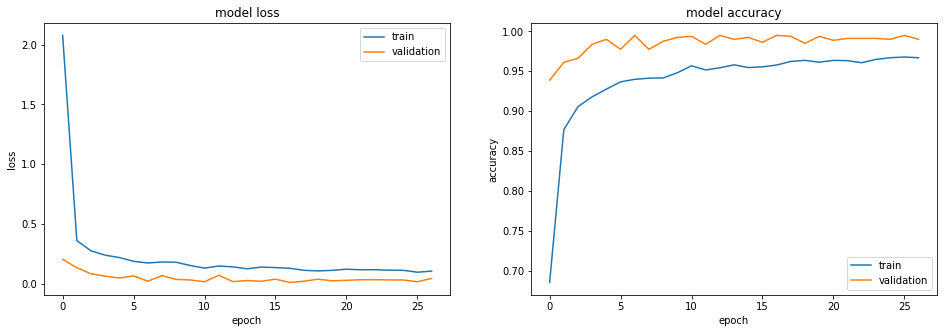

In [16]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [15]:
model.evaluate(test_generator)

50/50 [==============================] - 247s 5s/step - loss: 0.0169 - accuracy: 0.9960


[0.016938036307692528, 0.9959999918937683]

In [17]:
train_generator.class_indices

{'갈아만든배': 0,
 '레쓰비': 1,
 '마운틴듀': 2,
 '밀키스': 3,
 '스프라이트': 4,
 '칠성사이다': 5,
 '코카콜라': 6,
 '트로피카나망고': 7,
 '펩시콜라': 8,
 '환타오렌지': 9}

In [18]:
test_img = cv2.imread('./Pepsi_cola.jpg')  # 펩시콜라 : 8
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)

array([[2.05928959e-22, 5.01239002e-02, 1.24050895e-10, 1.73379852e-14,
        1.71684658e-08, 1.07605444e-16, 8.26482274e-17, 1.94813804e-19,
        9.49876070e-01, 2.26534032e-14]], dtype=float32)

In [19]:
test_img = cv2.imread('./fanta_orange.jpg')  # 환타오렌지 : 9
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(224,224))/255.0
test_img = test_img.reshape((1,)+test_img.shape)
model.predict(test_img)
# 판별 성공

array([[8.7908153e-12, 1.4060196e-08, 4.9829219e-18, 1.7124617e-25,
        2.8017714e-12, 1.8716873e-19, 1.6027617e-17, 1.2834796e-07,
        2.7075359e-10, 9.9999988e-01]], dtype=float32)